In [8]:
import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt #used for creating plots
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline


In [9]:
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    
    return txt_files

In [10]:
def file_to_df(path):
    df_raw = pd.read_csv(path,na_values = ['NAN', "00nan"], sep=" ")
    
    #timestamp_lst = []
    timestamp_lst = list(np.full(len(df_raw),0))
    for t in range(len(df_raw)):
        timestamp_lst[t] = pd.Timestamp(str(df_raw["YYYY"][t])+"-"+str(df_raw["MM"][t])+"-"+str(df_raw["DD"][t]) +" "+str(df_raw["Hr"][t])+":"+str(df_raw["Min"][t])+":"+str(df_raw["Sec"][t]),freq = ".1S")
    
    df = pd.DataFrame()
    df["Timestamp"] = timestamp_lst
    df["U"] = df_raw["U"]
    df["W"]=df_raw["W"]
    df["T"]=df_raw["T"]
    
    return df

def Calculations(df_raw, n):
    
    df_working = pd.DataFrame()
    df_working["Timestamp"] = df_raw["Timestamp"]
    df_working["W"]=df_raw["W"]
    df_working["T"]=df_raw["T"]

    #### Calculating the W', T' averages

    W_average = np.nanmean(df_raw["W"][:n])
    T_average = np.nanmean(df_raw["T"][:n])

    W_prime, T_prime= list(np.full(len(df_raw),np.nan)),list(np.full(len(df_raw),np.nan))
    for i in range(len(df_raw)):
        W_prime[i] = df_raw["W"][i]-W_average
        T_prime[i] = df_raw["T"][i]-T_average
    
    ## W'T' 
    wt = list(np.full(len(W_prime),np.nan))
    for i in range(len(W_prime)):
        wt[i] = (W_prime[i]*T_prime[i])
    
    ### Making the Quad list for all the points
    quad = list(np.full(len(df_working),0)) 
    for i in range(len(df_working)):
        #quad_mag.append(abs(W_prime[i]*T_prime[i]))
        if float(W_prime[i]) > 0 and float(T_prime[i]) > 0:
            quad[i] = 1
            continue
        if float(W_prime[i]) > 0 and float(T_prime[i]) < 0:
            quad[i] = 2
            continue
        if float(W_prime[i]) < 0 and float(T_prime[i]) < 0:
            quad[i] = 3
            continue
        if float(W_prime[i]) < 0 and float(T_prime[i]) > 0:
            quad[i] = 4
            continue



    df_working["Quad"] = quad
    #df_working["Quad_Mag"] = quad_mag
    df_working["T'W'"] = wt
    df_working = df_working.set_index("Timestamp")

    pre_quad_list = list(quad[:n])

    pre_Q1, pre_Q2 = pre_quad_list.count(1), pre_quad_list.count(2)
    pre_Q3, pre_Q4 = pre_quad_list.count(3), pre_quad_list.count(4)
    pre_nan = pre_quad_list.count(0)
    
    pre_sum = pre_Q1 + pre_Q2 + pre_Q3 + pre_Q4
    if pre_sum != 0: 
        pre_Qlst = [pre_Q1/pre_sum, pre_Q2/pre_sum, pre_Q3/pre_sum, pre_Q4/pre_sum]
    if pre_sum == 0:
        pre_Qlst = [0, 0, 0, 0]
    
    #Calculate the average W'T' for pre 
    pre_wt_prime_ave = np.nanmean(wt[:n])
    
    
    x_fire, fire_5sig = 9e10, np.nanmean(df_working["T"])+5*np.std(df_working["T"]) 
    for i in range(len(df_working["T"])):
        if df_working["T"][i] > fire_5sig:
            x_fire = i
            break
            
    return pre_Qlst, pre_wt_prime_ave, df_working, x_fire
    
def burn_calculations(df_working, x_fire):
    wt = list(df_working["T'W'"])
    brn_wt_prime_ave = np.nanmean(wt[x_fire:])
    
    brn_n = len(wt[x_fire:])
    brn_quad_list=list(df_working["Quad"][x_fire:])
    brn_Q1, brn_Q2 =brn_quad_list.count(1), brn_quad_list.count(2)
    brn_Q3, brn_Q4 =brn_quad_list.count(3), brn_quad_list.count(4)

    brn_sum = brn_Q1+ brn_Q2+ brn_Q3 + brn_Q4
    if brn_sum !=0:
        brn_Qlst = [brn_Q1/brn_sum, brn_Q2/brn_sum, brn_Q3/brn_sum, brn_Q4/brn_sum]
    if brn_sum == 0:
        brn_Qlst = [0, 0, 0, 0]
        
    return brn_Qlst, brn_wt_prime_ave,brn_n


In [11]:
#df_raw  = pd.read_csv(path + txt_files[i],na_values = ['NAN', "00nan"], sep="\t")
#pre_Qlst,brn_Qlst, pre_wt_prime_ave, brn_wt_prime_ave, x_fire,brn_n= Calculation(df_raw, 30000)

###### Variables needed
## pre_Qlst, brn_Qlst, pre_wt_prime_ave, brn_wt_prime_ave, x_fire,brn_n

def burn_averages(path, n):
    txt_files = text_finder(path)
    
    df_sonics_list =[]
    pre_burn_Q_lst, burn_Q_lst= [], []
    pre_WT_ave, brn_WT_ave = [],[]
    x_fire_lst, brn_n_lst= [], []
    for i in range(16):
        df_raw  = file_to_df(path + txt_files[i])
        pre_Qlst, pre_wt_prime_ave, df_working, x_fire = Calculations(df_raw, n)
        
        df_sonics_list.append(df_working)
        pre_burn_Q_lst.append(pre_Qlst)
        pre_WT_ave.append(pre_wt_prime_ave)
        x_fire_lst.append(x_fire)
        
    n_fire = min(x_fire_lst)
    for i in range(16):
        
        brn_Qlst, brn_wt_prime_ave, brn_n = burn_calculations(df_sonics_list[i], n_fire)
        brn_WT_ave.append(brn_wt_prime_ave)
        burn_Q_lst.append(brn_Qlst)
        brn_n_lst.append(brn_n)
    
    
    brn_len_min = []
    for i in range(len(brn_n_lst)):
        brn_len_min.append(brn_n_lst[i]/(600))
    
    axs2_ytic_loc = np.arange(round(np.min(brn_len_min),0),round(np.max(brn_len_min)+.5,0),1)
    
    return pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, brn_n_lst, axs2_ytic_loc, brn_len_min
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice


Wall time: 2h 38min 40s


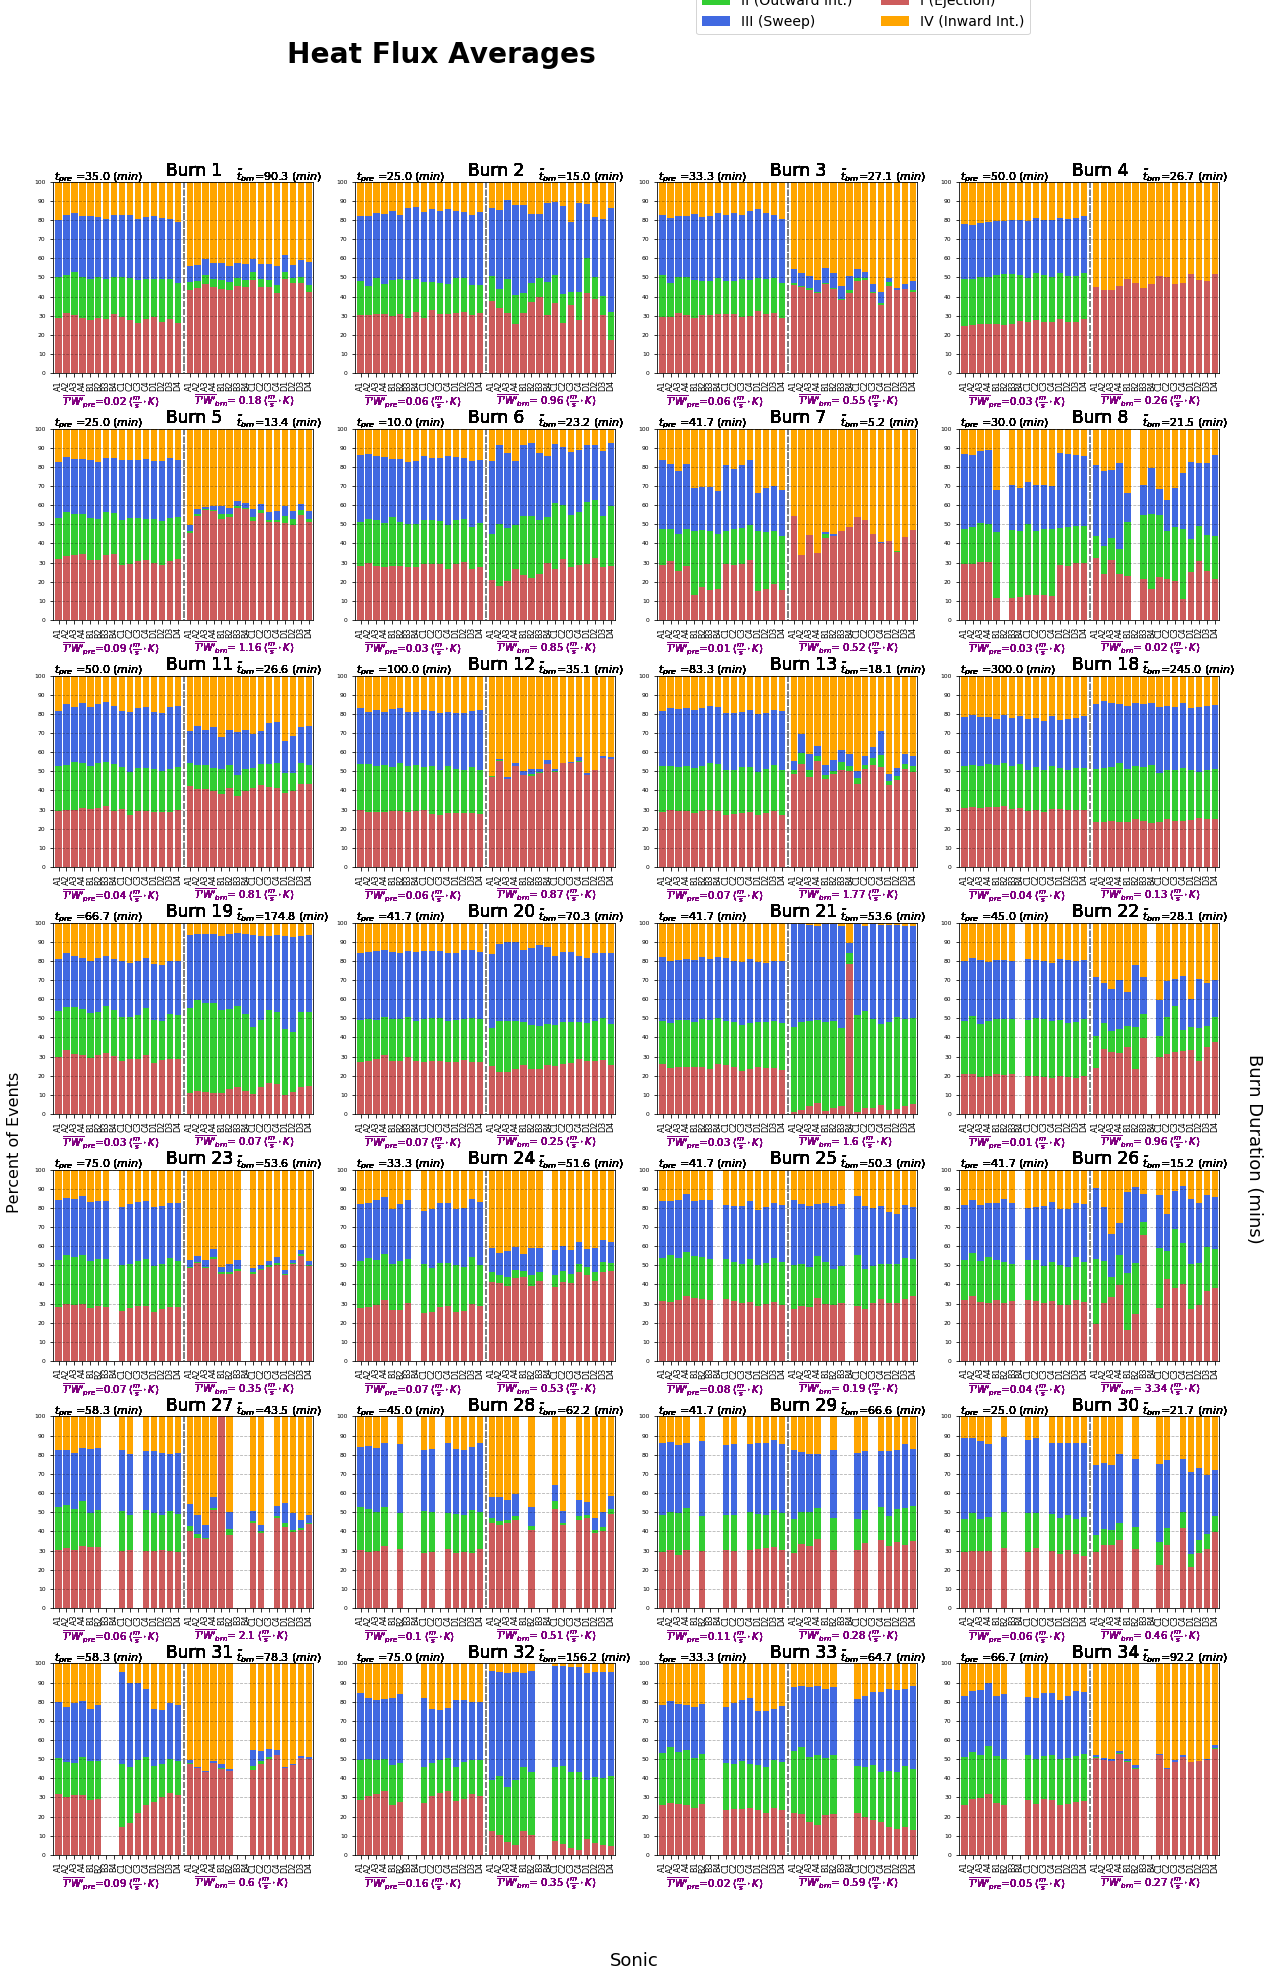

In [15]:
%%time
n_list = [21000,15000,20000,30000,15000,6000,25000,18000,30000,60000,50000,180000,40000,25000,25000,27000,\
         45000,20000,25000,25000,35000,27000,25000,15000,35000,45000,20000,40000]
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-" #79 
path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-" #w10
path_end = "/sonics/"
burns = [1,2,3,4,5,6,7,8,11,12,13,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]

### Plotting stuff 
sonic_list = ["A1","A2","A3","A4", "B1","B2", "B3", "B4", "C1", "C2","C3", "C4", "D1", "D2", "D3", "D4"]*2
x_loc_1= list(np.arange(1,17,1))
x_loc_2 = list(np.arange (17.5,33,1))
x_loc = x_loc_1 + x_loc_2

y_loc =np.arange(0.0,1.1,0.1)
y_tick_names  = np.arange(0,110,10)
fig, ax = plt.subplots(nrows=7,ncols=4,figsize=(18,28))#, sharey=True)
### Keep out of loop
file_count = 0
for col in range(7):
    for row in range(4):
        burn_path= str(path + str(burns[file_count])+path_end)
        pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, brn_n_lst, axs2_ytic_loc, brn_len_min = burn_averages(burn_path, n_list[file_count])
        
        axs = ax[ col, row]

        x1, x2 = 1, 17.5
        for i in range(16):
            axs.bar(x1, pre_burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=pre_burn_Q_lst[i][0])
            axs.bar(x1, pre_burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1])
            axs.bar(x1, pre_burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
            axs.bar(x1, pre_burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1]+pre_burn_Q_lst[i][2])

            axs.bar(x2, burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=burn_Q_lst[i][0])
            axs.bar(x2, burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1])
            axs.bar(x2, burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
            axs.bar(x2, burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1]+burn_Q_lst[i][2])

            axs.vlines(16.75,1,0, linestyle = "--", color = "grey")#alpha = .7)
            #axs.vlines(33.25,1,0, linestyle = "--",color = "grey")
            axs.set_ylim(0,1)
            axs.set_xlim(.25,33)
            axs.yaxis.grid(linestyle='--', color = "k", alpha = .3)
            axs.set_yticks(y_loc) 
            axs.set_yticklabels(y_tick_names, fontsize = 6)


            #axs.set_title("Pre-Burn Period"+"  "*35+ "Burn Period", fontsize = 16, x = .2)
            #axs.set_ylabel("Percent of Events", fontsize = 10)
            #axs.set_xlabel("Sonic", fontsize = 18, x=.47)
            pre_txt = r" ${t}_{pre}$ ="+str(round(n_list[file_count]/600,1))+" $(min)$"
            brn_txt =r" $\tilde{t}_{brn}$="+str(round(np.median(brn_len_min),1))+" $(min)$"
            axs.text(14.5,1.03, "Burn "+str(burns[file_count]), fontsize = 17)
            
            axs.text(23,1.01,brn_txt, fontsize = 11, weight = "light"  )
            axs.text(0,1.01,pre_txt, fontsize = 11, weight = "light" )

            axs.text(1,-.17," $\overline{T{}'W{}'}_{pre}$=" + str(round(np.nanmean(pre_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)" , fontsize = 10, color = "purple")
            axs.text(18,-.17, "$\overline{T{}'W{}'}_{brn}$= " + str(round(np.nanmean(brn_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)", fontsize = 10, color = "purple")

            #axs2 = axs.twinx()
            #axs2.boxplot(brn_len_min,widths=1, positions = [34.25])

            #axs2.set_yticks(axs2_ytic_loc)
            #axs2.tick_params(axis="y", labelsize=6)
            #for i in range(len(brn_len_min)):
            #    if brn_len_min[i]> np.median(brn_len_min)+stats.iqr(brn_len_min)*1.5 or \
            #        brn_len_min[i]<np.median(brn_len_min)-stats.iqr(brn_len_min)*1.5:

            #       axs2.text(35.25, brn_len_min[i], sonic_list[i],fontsize=6, weight = "light", color = "b")

            axs.set_xticks(x_loc)
            axs.set_xticklabels(sonic_list, fontsize=8,rotation='vertical')   
      
            x1 += 1
            x2 += 1
        file_count += 1 
    
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:4], labels[:4], ncol = 2, fontsize = 14, bbox_to_anchor=(.8, .99), framealpha = .8)
fig.suptitle("Heat Flux Averages", fontsize = 28, y = .97, x = .35, fontweight = "bold")
fig.text(0.015,0.39,"Percent of Events", rotation  = 90, fontsize = 16)
fig.text(0.97, 0.375,"Burn Duration (mins)", rotation = 270, fontsize = 18)
fig.text(0.48,0.015, "Sonic", fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(hspace=0.29,wspace=0.16, top=0.9, left = 0.05, right = .95, bottom = .07)

fig.savefig("rough_aveplot_1.png", dpi = 350)
### Took 56mins and 45s to run on W10 Desktop

In [ ]:
sonic_list = ["A1","A2","A3","A4", "B1","B2", "B3", "B4", "C1", "C2","C3", "C4", "D1", "D2", "D3", "D4"]
x_loc= np.arange(1,17,1)
y_loc =np.arange(0.0,1.1,0.1)
y_tick_names  = np.arange(0,110,10)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(14,8),sharex=True, sharey=True)
ax1 = axs[ 0]
x = 1
for i in range(16):
    ax1.bar(x, pre_burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=pre_burn_Q_lst[i][0])
    ax1.bar(x, pre_burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1])
    ax1.bar(x, pre_burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
    ax1.bar(x, pre_burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1]+pre_burn_Q_lst[i][2])
    ax1.set_ylim(0,1)
    ax1.set_yticks(y_loc)
    ax1.set_yticklabels(y_tick_names)
    ax1.set_xticks(x_loc)
    ax1.set_xticklabels(sonic_list)
    ax1.set_title(r"Pre-Burn Period", fontsize = 16, x = .7)
    ax1.text(11,-.07," $\overline{T{}'W{}'}$ =" + str(round(np.nanmean(pre_WT_ave), 2)) + r" ($\frac{m}{s} \cdot {K}$)", fontsize = 14, color = "purple")
    x += 1

x=1
ax2 = axs[ 1]
for i in range(16):
    ax2.bar(x, burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=burn_Q_lst[i][0])
    ax2.bar(x, burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1])
    ax2.bar(x, burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
    ax2.bar(x, burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1]+burn_Q_lst[i][2])
    ax2.set_ylim(0,1)
    ax2.set_xlim(.25,16.25)
    ax2.set_xticks(x_loc)
    ax2.set_xticklabels(sonic_list)
    ax2.set_title("Burn Period", x=.5, fontsize = 16)
    ax2.text(11,-.07, "$\overline{T{}'W{}'}$ = " + str(round(np.nanmean(brn_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)", fontsize = 14, color = "purple")
    x += 1

ax1.yaxis.grid(linestyle='--', color = "k", alpha = .7)
ax2.yaxis.grid(linestyle='--',color = "k", alpha = .7)
ax1.set_ylabel("Percent of Events", fontsize = 16)
ax1.set_xlabel("Sonic", fontsize = 16)
ax2.set_xlabel("Sonic",fontsize = 16)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles[:4], labels[:4], ncol = 2, fontsize = 12, bbox_to_anchor=(.625, .95), framealpha = .2)
fig.subplots_adjust(hspace=0.1,wspace=0)
fig.suptitle("Heat Flux Averages Burn 4", fontsize = 16, y = .97)
fig.savefig("rough_aveplot.png", dpi = 400)

In [ ]:
#for i in range(len(brn_Qlst)):
pre_burn_Q_lst

In [ ]:
pre_Q1_full, pre_Q2_full = [], []
pre_Q3_full, pre_Q4_full = [], []

brn_Q1_full, brn_Q2_full = [], []
brn_Q3_full, brn_Q4_full = [], []

for i in range(16):
    pre_Q1_full.append(pre_burn_Q_lst[i][0])
    pre_Q2_full.append(pre_burn_Q_lst[i][1])
    pre_Q3_full.append(pre_burn_Q_lst[i][2])
    pre_Q4_full.append(pre_burn_Q_lst[i][3])
    
    brn_Q1_full.append(burn_Q_lst[i][0])
    brn_Q2_full.append(burn_Q_lst[i][1])
    brn_Q3_full.append(burn_Q_lst[i][2])
    brn_Q4_full.append(burn_Q_lst[i][3])

In [ ]:
PQ1, PQ2 = sum(pre_Q1_full)/16, sum(pre_Q2_full)/16
PQ3, PQ4 = sum(pre_Q3_full)/16, sum(pre_Q4_full)/16

BQ1, BQ2 = sum(brn_Q1_full)/16, sum(brn_Q2_full)/16
BQ3, BQ4 = sum(brn_Q3_full)/16, sum(brn_Q4_full)/16

<BarContainer object of 1 artists>

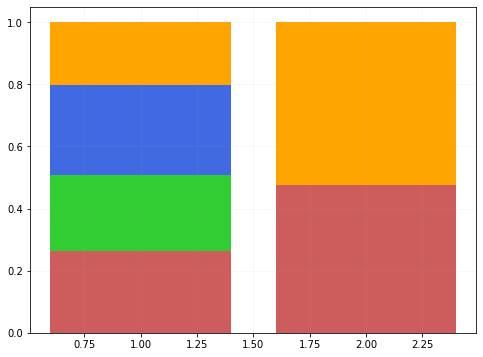

In [11]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,6),sharex=True, sharey=True)
axs.grid(alpha = .1)
axs.bar(1, PQ2,label = "II (Outward Int.)",color = "limegreen", bottom=PQ1)
axs.bar(1, PQ3,label = "III (Sweep)",color ="royalblue", bottom=PQ1+PQ2)
axs.bar(1, PQ1,label = "I (Ejection)",color="indianred")
axs.bar(1, PQ4,label = "IV (Inward Int.)",color = "orange",  bottom=PQ1+PQ2+PQ3)

axs.bar(2, BQ2,label = "II (Outward Int.)",color = "limegreen", bottom=BQ1)
axs.bar(2, BQ3,label = "III (Sweep)",color ="royalblue", bottom=BQ1+BQ2)
axs.bar(2, BQ1,label = "I (Ejection)",color="indianred")
axs.bar(2, BQ4,label = "IV (Inward Int.)",color = "orange",  bottom=BQ1+BQ2+BQ3)


NameError: name 'sonic_list' is not defined

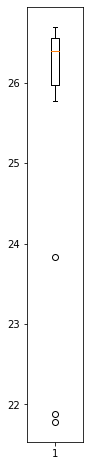

In [7]:


#fig, axs = plt.subplots(figsize = (1,8))
#axs.boxplot(brn_len_min, positions = [1])   
    
#for i in range(len(brn_len_min)):
#    if brn_len_min[i]> np.median(brn_len_min)+stats.iqr(brn_len_min)*1.5 or \
#        brn_len_min[i]<np.median(brn_len_min)-stats.iqr(brn_len_min)*1.5:
#        
#        axs.text(1.05, brn_len_min[i], sonic_list[i])

In [3]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/" #79 location
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #w10 location

#txt_files = text_finder(path)
#df_raw  = pd.read_csv(path + txt_files[0],na_values = ['NAN', "00nan"], sep="\t")  


#print(len(txt_files))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/'